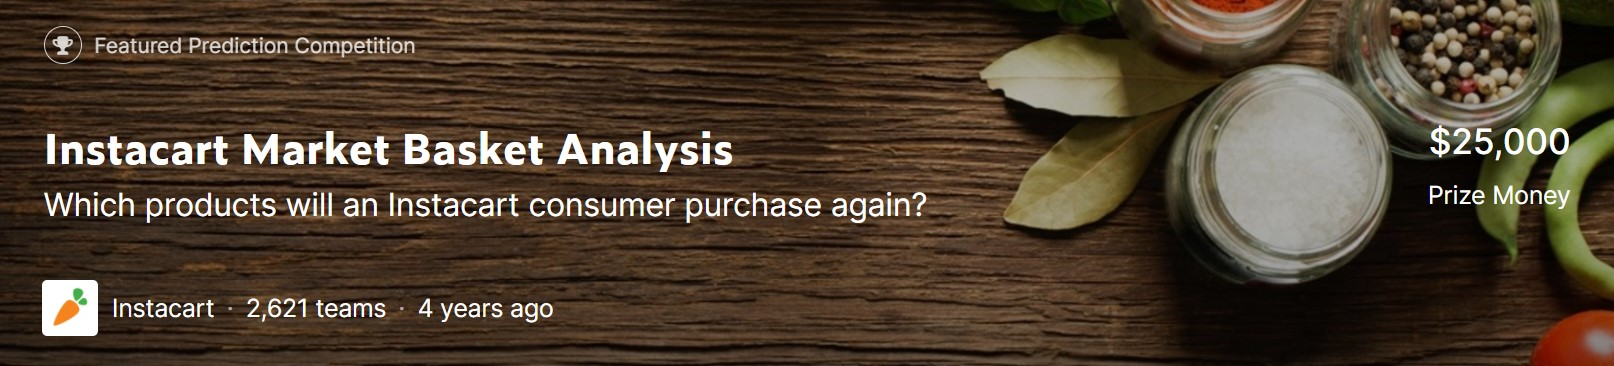

In [1]:
from IPython.core.display import Image, display
display(Image(filename = "../ML Final project/instacart-market-basket-analysis/logo.jpg", width=1000))

# Instacart Market Basket Analysis

### Anderson Alves

#### *August, 2021*

<br>
<small>This 2 week project was done as part of the course <i>Machine Learning with Python: Zero to GBMs</i>, a 6 week course lectured by Aakash N. S., and hosted on <a href="https://jovian.ai">Jovian.ai</a>.</small>


The Zero to GBMs course focuses on supervised machine learning, decision trees, and gradient boosting using Python and its ecosystem of ML libraries: scikit-learn, XGBoost, and LightGBM.

For this course project I have selected the **Instacart Market Basket Analysis**, a <a href="https://kaggle.com">Kaggle.com</a> competition, to perform data cleaning & feature engineering as well as training, comparing & tuning machine learning models to create a recommendation system to predict future behavior of users based on the provided data.


### Acknowledgements

The dataset was provided by Instacart and its data was downloaded from  <a href="https://www.kaggle.com/c/instacart-market-basket-analysis/data">Kaggle's data bank</a>.

# 1. Business Problem

<br>

<div style="text-align:justify">This dataset comes from a competition hosted by Instacart on Kaggle. Instacart is a company that operates a grocery delivery and pick-up service. It allows customers to order groceries from multiple retailers and the shopping is done by a personal shopper. The service has a recommendation feature that suggests to the users some items that they may buy again when making a new order.<br>

In this competition, Instacart challenged the Kaggle community to use the provided anonymized data on customer orders over time to predict which previously purchased products will be in a user's next order.

Recommendation systems are now frequently used by online businesses. They use these systems to improve shopping potential and increase user interaction, allowing them to maximize their return on investment (ROI) based on the information gathered from customers' purchases and preferences. The knowledge-based Recommender System used by Instacart is an essential tool for those purposes by individually presenting more relevant products to each user.  </div> 


## 1.1 Dataset Content

The dataset contains about 3.4 million grocery orders from 200 thousand Instacart users. The data is distributed among 6 csv files and a submission sample:
 - aisles
 - departments
 - orders
 - order_products__prior
 - order_products__train
 - products
 - sample_submission
 
Each order is evaluated as prior, train, or test. Prior orders are the past behavior of the users while train and test orders represent the future behavior that we need to predict. Each user is divided between the train and test groups, and all of them have information on the different products purchased in all of their prior orders.

For the train category, the reordered products are already described, and we will use those to train a classification model to predict the products of the orders from the test category that are going to be reordered.

## 1.2. Solution Strategy
My strategy to solve this challenge was:

**Step 01.** Obtain and unpack the data from the source. <br>
**Step 02.** Data Filtering. <br>
**Step 03.** Exploratory Data Analysis. <br>
**Step 04.** Feature Engeneering. <br>
**Step 05.** Data Preparation. <br>
**Step 06.** Feature Selection. <br>
**Step 07.** Machine Learning Modelling: XGBoost & LightGBM. <br>
**Step 08.** Parameter Tunning. <br>
**Step 09.** Evaluate Models Performance. <br>

------------------

### Importing packages and downloading data

In [2]:
!pip install numpy pandas matplotlib seaborn --quiet
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm tabulate --upgrade --quiet

In [93]:
# Jovian commit essentials
import jovian
jovian.set_project('course-project-machine-learning-local')

# Data analysis 
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np

# ML models
import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance
import lightgbm as lgb

# Models performance evaluation
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

# File saving
import joblib

# Plotting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
color = sns.color_palette()

# Miscellaneous
import warnings
from tabulate import tabulate
import gc

In [5]:
!pip install opendatasets --quiet
import opendatasets

### Downloading the data from Kaggle

In [6]:
import os
import opendatasets as od
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 120)

In [7]:
od.download('https://www.kaggle.com/c/instacart-market-basket-analysis')

Skipping, found downloaded files in ".\instacart-market-basket-analysis" (use force=True to force download)


In [8]:
os.listdir('instacart-market-basket-analysis')

['aisles.csv.zip',
 'departments.csv.zip',
 'logo.jpg',
 'orders.csv.zip',
 'order_products__prior.csv.zip',
 'order_products__train.csv.zip',
 'products.csv.zip',
 'sample_submission.csv.zip']

In [9]:
# Since the zip archives have multiple files, we need to unzip them first, then use de read_csv for each file, while converting numerical columns to each dtype:
from zipfile import ZipFile

path_dataset = 'E:\Jupyter Notes\ML Final project\instacart-market-basket-analysis'
zip_file = ZipFile(path_dataset+'/orders.csv.zip')
orders_df = pd.read_csv(zip_file.open('orders.csv'), dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})

zip_file = ZipFile(path_dataset+'/products.csv.zip')
products_df = pd.read_csv(zip_file.open('products.csv'), dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8})

zip_file = ZipFile(path_dataset+'/order_products__train.csv.zip')
order_products__train_df = pd.read_csv(zip_file.open('order_products__train.csv'), dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

zip_file = ZipFile(path_dataset+'/order_products__prior.csv.zip')
order_products__prior_df = pd.read_csv(zip_file.open('order_products__prior.csv'), dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})

zip_file = ZipFile(path_dataset+'/aisles.csv.zip')
aisles_df = pd.read_csv(zip_file.open('aisles.csv'))

zip_file = ZipFile(path_dataset+'/departments.csv.zip')
departments_df = pd.read_csv(zip_file.open('departments.csv'))

zip_file = ZipFile(path_dataset+'/sample_submission.csv.zip')
sample_submission = pd.read_csv(zip_file.open('sample_submission.csv'))

# 2. Exploratory Data Analysis

## 2.1 Understanding the dataset

In [10]:
# Checking all the created dataframes
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


This dataframe gives a list of all orders we have in the dataset. 1 row per order. For example, we can see that user 1 has 11 orders, 1 of which is in the train set, and 10 of which are prior orders. The orders.csv doesn’t tell us about which products were ordered. This is contained in the order_products_ csv files.

In [11]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


This dataframe contains the names of the products with their corresponding product_id. Furthermore the aisle and deparment are included.

In [12]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


This dataframe contains the different aisles that each item comes from.

In [13]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


This dataframe contains the different departments that each item comes from.

In [14]:
# Merging product related dfs as a single products_df
products_df = products_df.merge(aisles_df).merge(departments_df)
products_df.drop(['aisle_id', 'department_id'], axis=1, inplace=True)
products_df

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks
...,...,...,...,...
49683,22827,Organic Black Mission Figs,bulk dried fruits vegetables,bulk
49684,28655,Crystallized Ginger Chunks,bulk dried fruits vegetables,bulk
49685,30365,Vegetable Chips,bulk dried fruits vegetables,bulk
49686,38007,Naturally Sweet Plantain Chips,bulk dried fruits vegetables,bulk


In [15]:
order_products__train_df

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


This dataframe gives us information about which products (product_id) were ordered. It also contains information of the order (add_to_cart_order) in which the products were put into the cart and information of whether this product is a re-order(1) or not(0).

For example, we see below that order_id 1 had 8 products, 4 of which are reorders.

Still we don’t know what these products are. This information is in the products.csv

In [16]:
order_products__prior_df

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


This dataframe is structurally the same as the other_products_train.csv.

The last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_products_prior file. We can also note that there is a column in orders.csv file called eval_set which tells us as to which of the three datasets (prior, train or test) the given row goes to.

In [17]:
orders_df['eval_set'].unique()

['prior', 'train', 'test']
Categories (3, object): ['prior', 'test', 'train']

In [18]:
# Checking the sample submission file
sample_submission

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259
...,...,...
74995,3420740,39276 29259
74996,3420877,39276 29259
74997,3420888,39276 29259
74998,3420989,39276 29259


This dataframe contains a sample of the submission file that needs to be submitted for the competition.

For each order_id in the test set, we should predict a space-delimited list of productids for that order. If we wish to predict an empty order, we should submit an explicit 'None' value. We may combine 'None' with product_ids.

## 2.2 Exploring the data

In [19]:
# Checking the total amount of individual costumers present in the orders_df.
def get_unique_counts(x):
    return len(np.unique(x))

print(orders_df.groupby('eval_set')['user_id'].aggregate(get_unique_counts))

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64


We have a total of 206209 costumers in the orders_df, which are divided between the training and testing categories.

We'll need to predict the values for the costumers in the testing category.

Instacart states that for each user, it's provided between 4 and 100 of their orders, with the sequence of products purchased in each order. We can verify this in the following plot.

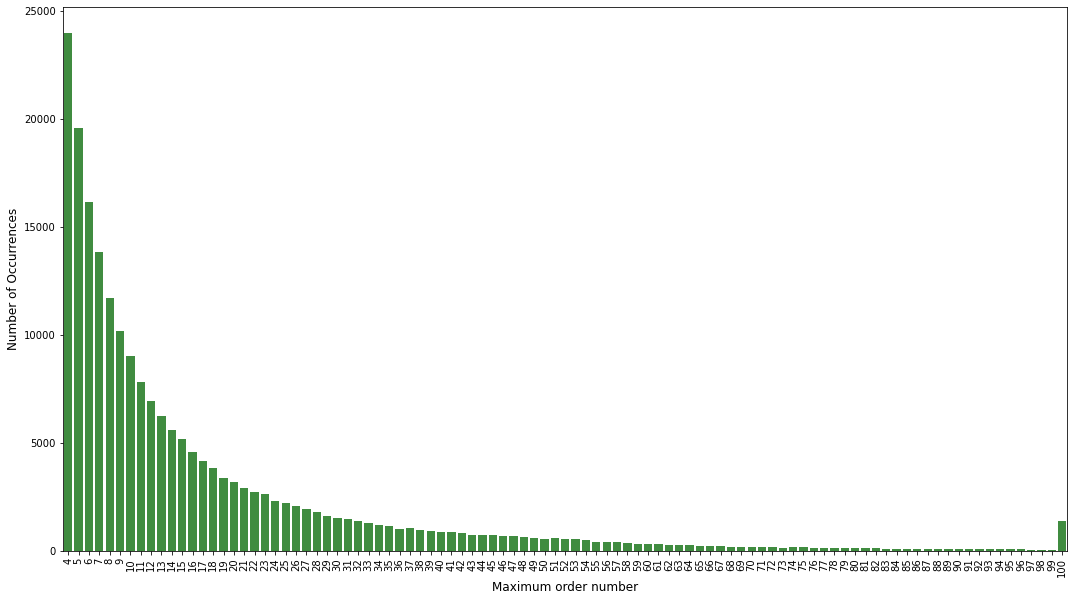

In [20]:
# Checking the occurrences of the maximum order numbers
order_num = orders_df.groupby('user_id')['order_number'].aggregate(np.max).reset_index()
order_num = order_num['order_number'].value_counts()

plt.figure(figsize=(18,10))
sns.barplot(x=order_num.index, y=order_num.values, alpha=0.8, color='green')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

From the above plot we can verify that the user orders are indeed between 4 and 100. The minimum amount of orders for each user is 4 and the maximum is 100.

We can check the most common day of the week users order.

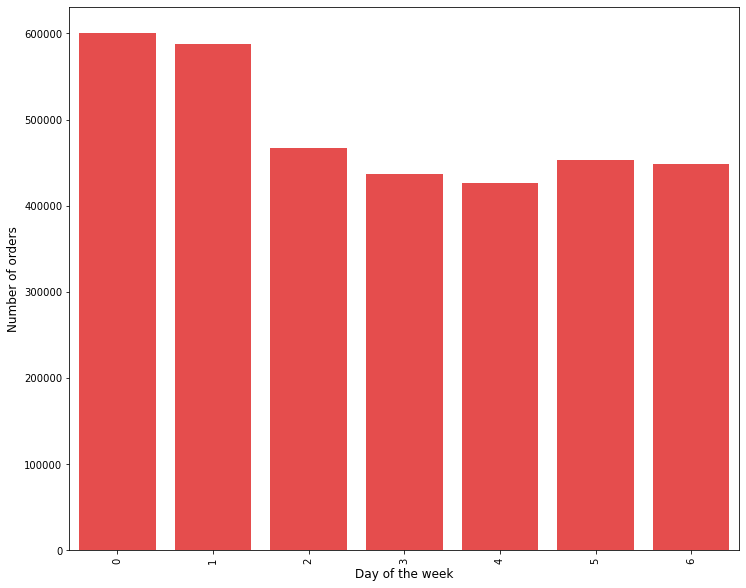

In [21]:
# Checking the orders by day of the week
orders_dow = orders_df['order_dow']

plt.figure(figsize=(12,10))
sns.countplot(x=orders_dow, data=orders_df, alpha=0.8, color='red')
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Day of the week', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

There's no info regarding what each number represents, but we can assume from the plot that 0 and 1 are probably the weekend, since the amount of orders is much larger. So, lets assume that 0 is Saturday and 1 is Sunday.

Therefore,  the day with the  lowest amount of orders is Wednesday. 

We can also evaluate the time of the day the orders are most common.

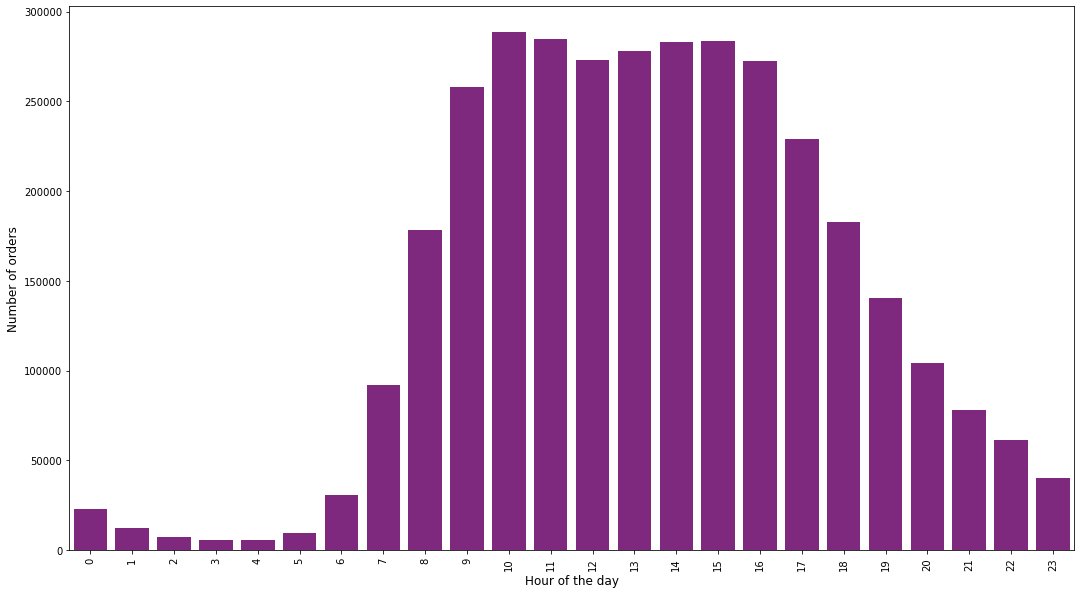

In [22]:
# Checking the orders by hour of the day
orders_hotd = orders_df['order_hour_of_day']

plt.figure(figsize=(18,10))
sns.countplot(x=orders_hotd, data=orders_df, alpha=0.9, color='purple')
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Hour of the day', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The number of orders quickly rises after 7AM and reach the maximum at 10AM, maintaining a high amount up to 5PM, where it starts to decrease.

Now we can check the average amount of days between orders that the users take.

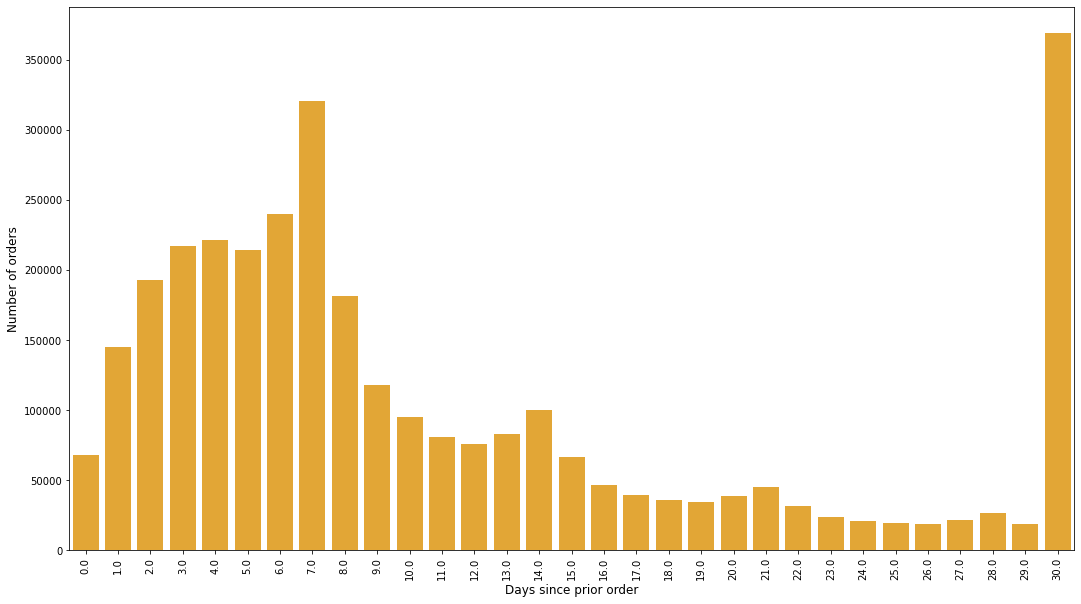

In [23]:
# Checking the amount of days since last order
orders_dspo = orders_df['days_since_prior_order']

plt.figure(figsize=(18,10))
sns.countplot(x=orders_dspo, data=orders_df, alpha=0.9, color='orange')
plt.ylabel('Number of orders', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

We can see most of the orders are taken in monthly intervals, followed by weekly intervals, with peaks at 7, 14, 21 and 28 days.

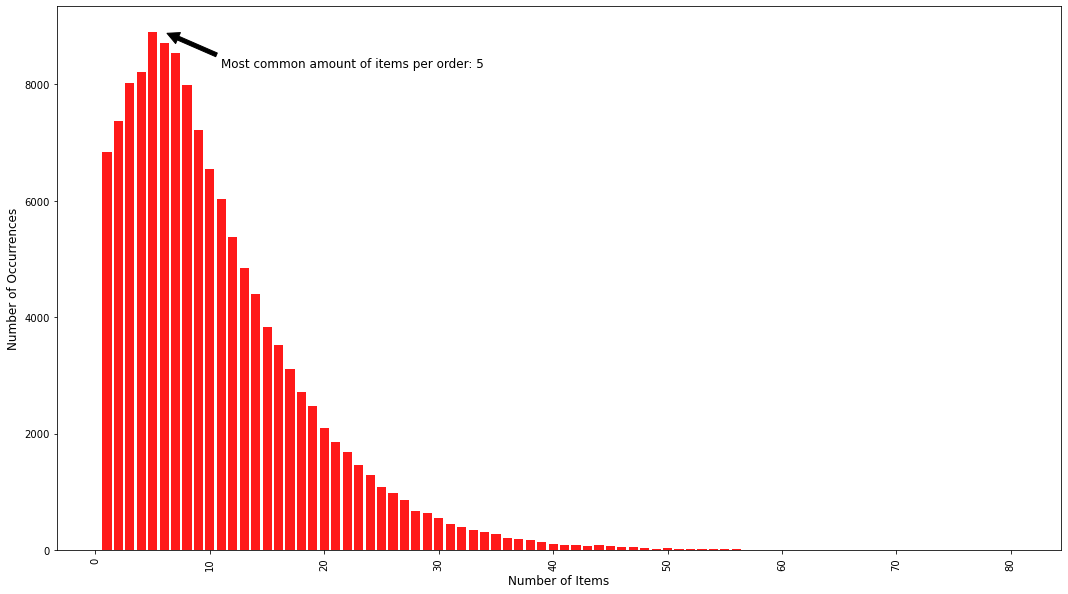

In [24]:
product_amount = order_products__train_df.groupby('order_id')['add_to_cart_order'].aggregate(np.max).reset_index()
product_count = product_amount.add_to_cart_order.value_counts()

fig, ax = plt.subplots(figsize=(18,10))

ax.bar(x=product_count.index, height=product_count.values, alpha=0.9, color = 'red')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of Items', fontsize=12)
plt.xticks(rotation='vertical')
ax.annotate('Most common amount of items per order: {:.0f}'.format(product_count.idxmax()), xy=(6, 8900), xytext=(11, 8300), fontsize=12, arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

The most common order has an average of 5 items. With that in mind, lets check which items are the bestsellers.

In [25]:
bestsellers = order_products__prior_df.groupby('product_id')['add_to_cart_order'].count().sort_values(ascending=False).reset_index()
# Merging dfs to get the product names for the best sellers
bestsellers = bestsellers.merge(products_df[['product_id','product_name']])
# Checking top 10
bestsellers.head(10)

,product_id,add_to_cart_order,product_name
0,24852,472565,Banana
1,13176,379450,Bag of Organic Bananas
2,21137,264683,Organic Strawberries
3,21903,241921,Organic Baby Spinach
4,47209,213584,Organic Hass Avocado
5,47766,176815,Organic Avocado
6,47626,152657,Large Lemon
7,16797,142951,Strawberries
8,26209,140627,Limes
9,27845,137905,Organic Whole Milk


The top 9 bestsellers in prior orders are all produce items, with the top 1 being Banana, followed by Organic Whole Milk.

In [26]:
bestsellers_train = order_products__train_df.groupby('product_id')['add_to_cart_order'].count().sort_values(ascending=False).reset_index()
# Merging dfs to get the product names for the best sellers
bestsellers_train = bestsellers_train.merge(products_df[['product_id','product_name']], on='product_id')
# Checking top 10
bestsellers_train.head(10)

,product_id,add_to_cart_order,product_name
0,24852,18726,Banana
1,13176,15480,Bag of Organic Bananas
2,21137,10894,Organic Strawberries
3,21903,9784,Organic Baby Spinach
4,47626,8135,Large Lemon
5,47766,7409,Organic Avocado
6,47209,7293,Organic Hass Avocado
7,16797,6494,Strawberries
8,26209,6033,Limes
9,27966,5546,Organic Raspberries


For the train dataframe, the top 3 items are the same, and the other items are in  similar positions.

In [27]:
products_df.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


# 3. Feature engineering and data preparation for modeling

With the knowledge obtained from the EDA and the details from the products purchased in the prior orders, it's possible to obtain more details.

To check the information divided by each user, we have to make some features.

In [28]:
# merging products related dataframes with orders
products = products_df.merge(aisles_df).merge(departments_df)
products.drop(["aisle_id", "department_id"], axis=1, inplace=True)
ordert = order_products__train_df.merge(orders_df[["order_id","user_id"]])
orders_products = order_products__prior_df.merge(orders_df)

In [29]:
# getting products ordered first and second times to calculate probability
prd2 = orders_products.sort_values(['user_id', 'order_number', 'product_id'], ascending=True)
prd2['product_time'] = orders_products.groupby(['user_id', 'product_id']).cumcount()+1
sub1 = prd2[prd2['product_time'] == 1].groupby('product_id').size().to_frame('prod_first_orders')
sub2 = prd2[prd2['product_time'] == 2].groupby('product_id').size().to_frame('prod_second_orders')
sub1['prod_orders'] = prd2.groupby('product_id')['product_id'].size()
sub1['prod_reorders'] = prd2.groupby('product_id')['reordered'].sum()
sub2 = sub2.reset_index().merge(sub1.reset_index())
# calculating probability and ratio
sub2['prod_reorder_probability'] = sub2['prod_second_orders']/sub2['prod_first_orders']
sub2['prod_reorder_ratio'] = sub2['prod_reorders']/sub2['prod_orders']

prd = sub2[['product_id', 'prod_orders','prod_reorder_probability', 'prod_reorder_ratio']]

#release memory
del sub1, sub2, prd2
gc.collect()

39253

In [30]:
# merging users related dataframes with orders
orders_df["user_mean_days_since_prior"] = orders_df.days_since_prior_order
users = orders_df[orders_df.eval_set == "prior"].groupby("user_id").agg({ "order_number" : "max", "days_since_prior_order" : "sum", "user_mean_days_since_prior" : "mean" }).rename(columns = { "order_number" : "user_orders", "days_since_prior_order" : "user_period" })
users.reset_index(inplace=True)
# calculating reordered amount, amount of orders, and number of distinct products 
us = orders_products.groupby("user_id").agg({ "order_id" : "count", "reordered" : "sum", "order_number" : lambda rows: rows[rows > 1].shape[0], "product_id" : "nunique" }).rename(columns = { "order_id" : "user_total_products", "product_id" : "user_distinct_products"})
# calculating the user reorder ratio
us["user_reorder_ratio"] = us.reordered / us.order_number
us.drop(["reordered", "order_number"], axis=1, inplace=True)
us.reset_index(inplace=True)
# merging data
users = users.merge(us)
users["user_average_basket"] = users.user_total_products / users.user_orders
us = orders_df[orders_df.eval_set != "prior"][["user_id", "order_id", "eval_set", "days_since_prior_order"]].rename(columns = { "days_since_prior_order" : "time_since_last_order" })
users = users.merge(us)

In [31]:
# data final preparation for modelling
orders_products["up_orders"] = orders_products["up_first_order"] = orders_products["up_last_order"] = orders_products.order_number
data = orders_products.groupby(["user_id", "product_id"]).agg({ "up_orders" : "count", "up_first_order" : "min", "up_last_order" : "max", "add_to_cart_order" : "mean" }).rename(columns={ "add_to_cart_order" : "up_average_cart_position" })
data.reset_index(inplace=True)
# merging products and users information
data = data.merge(prd).merge(users)
# calculating the user + product order rate, orders since last order and order rate since last order
data["up_order_rate"] = data.up_orders / data.user_orders
data["up_orders_since_last_order"] = data.user_orders - data.up_last_order
data["up_order_rate_since_first_order"] = data.up_orders / (data.user_orders - data.up_first_order + 1)
# merging train info to the data
data = data.merge(ordert[["user_id", "product_id", "reordered"]], how="left", on=["user_id", "product_id"])
# filling null values with the reordered = 0
data.loc[pd.isnull(data.reordered), "reordered"] = 0
data

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_ratio,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_distinct_products,user_reorder_ratio,user_average_basket,order_id,eval_set,time_since_last_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,reordered
0,1,196,10,1,10,1.400000,35791,0.582500,0.776480,10,176.0,19.555555,59,18,0.759259,5.9,1187899,train,14.0,1.000000,0,1.000000,1.0
1,1,10258,9,2,10,3.333333,1946,0.552962,0.713772,10,176.0,19.555555,59,18,0.759259,5.9,1187899,train,14.0,0.900000,0,1.000000,1.0
2,1,10326,1,5,5,5.000000,5526,0.521581,0.652009,10,176.0,19.555555,59,18,0.759259,5.9,1187899,train,14.0,0.100000,5,0.166667,0.0
3,1,12427,10,1,10,3.300000,6476,0.529482,0.740735,10,176.0,19.555555,59,18,0.759259,5.9,1187899,train,14.0,1.000000,0,1.000000,0.0
4,1,13032,3,2,10,6.333333,3751,0.479782,0.657158,10,176.0,19.555555,59,18,0.759259,5.9,1187899,train,14.0,0.300000,0,0.333333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13278018,120516,8566,5,1,5,1.000000,140,0.500000,0.614286,7,100.0,16.666666,7,2,0.833333,1.0,3264957,train,14.0,0.714286,2,0.714286,0.0
13278019,120516,40072,2,6,7,1.000000,25,0.466667,0.400000,7,100.0,16.666666,7,2,0.833333,1.0,3264957,train,14.0,0.285714,0,1.000000,1.0
13278020,166751,49001,3,1,3,1.000000,45,0.193548,0.311111,3,20.0,10.000000,3,1,1.000000,1.0,2080697,train,14.0,1.000000,0,1.000000,1.0
13278021,106143,19675,26,1,26,1.000000,39,0.833333,0.846154,26,191.0,7.640000,26,1,1.000000,1.0,1714200,test,9.0,1.000000,0,1.000000,0.0


In [32]:
#reduce the memory size by setting data types
data = data.astype(dtype= {'user_id' : np.uint32, 'product_id'  : np.uint16,
            'up_orders'  : np.uint8, 'up_first_order' : np.uint8, 'up_last_order' : np.uint8,
            'up_average_cart_position' : np.uint8, 'prod_orders' : np.uint16, 
            'prod_reorder_probability' : np.float16,   
            'prod_reorder_ratio' : np.float16, 'user_orders' : np.uint8,
            'user_period' : np.uint8, 'user_mean_days_since_prior' : np.uint8,
            'user_total_products' : np.uint8, 'user_reorder_ratio' : np.float16, 
            'user_distinct_products' : np.uint8, 'user_average_basket' : np.uint8,
            'order_id'  : np.uint32, 'time_since_last_order' : np.uint8,
            'up_order_rate_since_first_order' : np.float16, 
            'up_orders_since_last_order':np.uint8})

data['reordered'].fillna(0, inplace=True)  # replace NaN with zeros (not reordered) 
data['reordered']=data['reordered'].astype(np.uint8)

gc.collect()

0

In [33]:
# save data to file
joblib.dump(data, "data.joblib")

['data.joblib']

In [34]:
# data = joblib.load('data.joblib')

In [35]:
# check final data features
data.head()

,user_id,product_id,up_orders,up_first_order,up_last_order,up_average_cart_position,prod_orders,prod_reorder_probability,prod_reorder_ratio,user_orders,user_period,user_mean_days_since_prior,user_total_products,user_distinct_products,user_reorder_ratio,user_average_basket,order_id,eval_set,time_since_last_order,up_order_rate,up_orders_since_last_order,up_order_rate_since_first_order,reordered
0,1,196,10,1,10,1,35791,0.582520,0.776367,10,176,19,59,18,0.759277,5,1187899,train,14,1.0,0,1.000000,1
1,1,10258,9,2,10,3,1946,0.552734,0.713867,10,176,19,59,18,0.759277,5,1187899,train,14,0.9,0,1.000000,1
2,1,10326,1,5,5,5,5526,0.521484,0.651855,10,176,19,59,18,0.759277,5,1187899,train,14,0.1,5,0.166626,0
3,1,12427,10,1,10,3,6476,0.529297,0.740723,10,176,19,59,18,0.759277,5,1187899,train,14,1.0,0,1.000000,0
4,1,13032,3,2,10,6,3751,0.479736,0.657227,10,176,19,59,18,0.759277,5,1187899,train,14,0.3,0,0.333252,1


# 4. Running Models

Training and evaluating XGBoost and LightGBM machine learning models to build a recommendation system.

## 4.1 Baseline Score

For a baseline score for our models, we'll assume that the users will just repeat their last order and evaluate that scenario as prediction.

The obtained models' scores are summarized and compared in Chapter 5.

In [36]:
# split test and last orders for baseline
test_orders = data[data.eval_set == 'test']
baseline = data[(data.user_id.isin(test_orders.user_id))].merge(orders_df[['order_id','order_number']].reset_index(drop=True))
last_orders = baseline.groupby('user_id')['order_number'].max()

last_orders_baseline = pd.merge(left=pd.merge(left=last_orders.reset_index(),right=baseline,how='inner',on=['user_id', 'order_number']
                              )[['user_id', 'product_id']],right=test_orders[['user_id', 'order_id']],how='left',on='user_id'
                ).groupby('order_id')['product_id'].apply(lambda x: ' '.join([str(e) for e in set(x)])).reset_index()
last_orders_baseline.columns = ['order_id', 'products']

# save submission
last_orders_baseline.to_csv('baseline_submission.csv', encoding='utf-8', index=False)

<b>Repeating user's last order Baseline</b>

Kaggle Score: 0.21671 

This score will be used as our baseline for the models and the improve above it will be measured.

## 4.2 XGBoost

In [37]:
# split test and train data and features to be discarded 
train = data[data.eval_set == "train"]
test = data[data.eval_set == "test"]
subtrain = train.sample(frac=1.0)
discard_fields = ["eval_set", "user_id", "product_id", "order_id", "reordered"]

### 4.2.1 XGBoost model default parameters

In [38]:
# Training a model with default XGBoost parameters 
X = xgb.DMatrix(subtrain.drop(discard_fields, axis=1), label=subtrain.reordered)

params = {}

#nrounds = 1000
#lowered to 10 for project evaluation
nrounds = 10

xgb_model_base = xgb.train(params, X, nrounds)

In [39]:
# save model to file
joblib.dump(xgb_model_base, "xgb_model_default.joblib")

['xgb_model_default.joblib']

In [40]:
# # load model from file
# xgb_model_base = joblib.load('xgb_model_default.joblib')

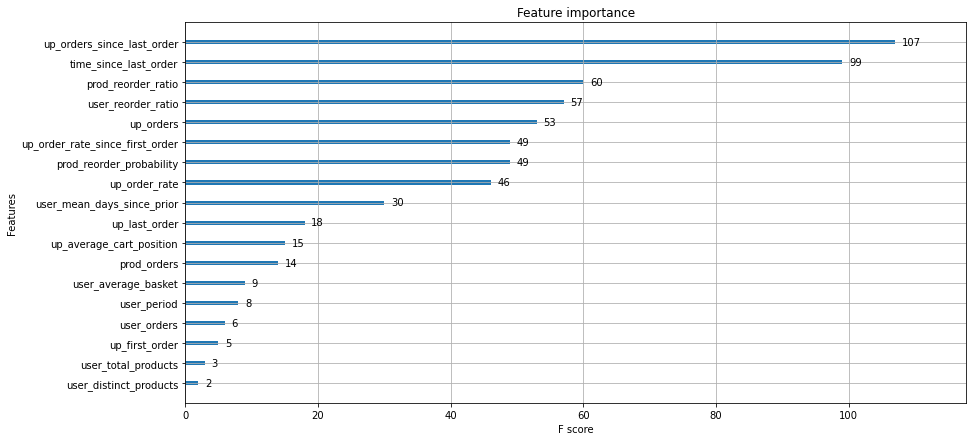

In [41]:
# plotting feature importance
plt.rcParams["figure.figsize"] = (14, 7)
xgb.plot_importance(xgb_model_base)
plt.show()

In [42]:
# Applying model with a 0.21 probability threshold
probability_threshold = 0.21
X = xgb.DMatrix(test.drop(discard_fields, axis=1))
# predict reordered products
test["reordered"] = xgb_model_base.predict(X)
test["reordered"] = np.where(test.reordered > probability_threshold, 1, 0)
test.loc[:, 'product_id'] = test.product_id.astype(str)
# join reordered products for submission
submission = test[test.reordered == 1].groupby("order_id").agg({ "product_id" : lambda x: ' '.join(x) })
submission.rename(columns = {"product_id" : "products"}, inplace=True)
submission.reset_index(inplace=True)
# get only the results for the test set
test_set = orders_df[orders_df.eval_set == "test"][["order_id"]]
test_set = test_set.merge(submission, how="outer")
test_set.sort_values("order_id", inplace=True)
# save file for submission
test_set.to_csv(("base_model_submission.csv"), columns=["order_id", "products"], index=False, na_rep="None")
test_set.head(10)

,order_id,products
13407,17,21709 47766 21463 13107
12775,34,13176 47766 47792 21137 44632 43504 39180 3947...
68056,137,41787 24852 5134 38689 25890 2326 23794
42239,182,47209 11520 39275 13629 47672 5479 33000 41149...
12915,257,49235 24852 27966 37646 22035 13870 27104 4605...
41326,313,21903 45007 13198 30391 28535 46906 25890 1277...
63247,353,21137 35561 40688
20242,386,30450 22124 24852 45066 47766 21903 42265 4920...
44019,414,21376 21709 36865 14947 44632 27845 31215 4472...
12171,418,30489 47766 41950 40268 13702 5262 38694


<b>XGB Default Parameters Score </b>

nrounds = 1000 \
probability_threshold = 0.21

Kaggle Score 0.37890

### 4.2.2 XGBoost parameters

In [43]:
# Model 
X = xgb.DMatrix(subtrain.drop(discard_fields, axis=1), label=subtrain.reordered)

params = {
  "objective"           : "binary:logistic",
  "eval_metric"         : "logloss",
  "eta"                 : 0.1,
  "max_depth"           : 6,
  "min_child_weight"    : 10,
  "gamma"               : 0.70,
  "subsample"           : 0.76,
  "colsample_bytree"    : 0.95,
  "alpha"               : 2e-05,
  "lambda"              : 10
}

#nrounds = 1000
#lowered to 10 for project evaluation
nrounds = 10

xgb_model = xgb.train(params, X, nrounds)

In [44]:
# save model to file
joblib.dump(xgb_model, "xgb_A_params.joblib")

['xgb_A_params.joblib']

In [45]:
# xgb_model = joblib.load('xgb_A_params.joblib')

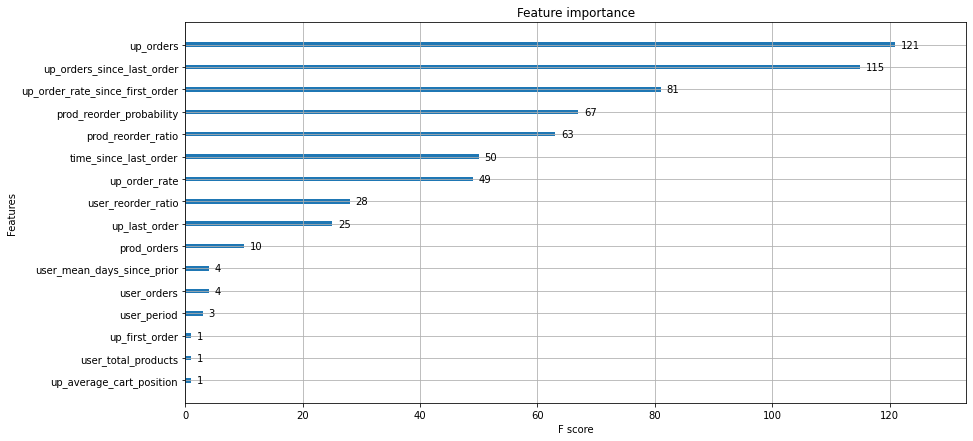

In [46]:
# plotting feature importance
plt.rcParams["figure.figsize"] = (14, 7)
xgb.plot_importance(xgb_model)
plt.show()

#### Evaluating different probability thresholds for XGBoost Model

In the previous sections, we used 0.21 as the probability threshold.\
To confirm if 0.21 is best for our models, we'll evaluate the scores with different threshold values.

In [47]:
# Apply model
probability_threshold = 0.18
X = xgb.DMatrix(test.drop(discard_fields, axis=1))
# predict reordered products
test["reordered"] = xgb_model.predict(X)
test["reordered"] = np.where(test.reordered > probability_threshold, 1, 0)
test.loc[:, 'product_id'] = test.product_id.astype(str)
# join reordered products for submission
submission = test[test.reordered == 1].groupby("order_id").agg({ "product_id" : lambda x: ' '.join(x) })
submission.rename(columns = {"product_id" : "products"}, inplace=True)
submission.reset_index(inplace=True)
# get only the results for the test set
test_set = orders_df[orders_df.eval_set == "test"][["order_id"]]
test_set = test_set.merge(submission, how="outer")
test_set.sort_values("order_id", inplace=True)
# save file for submission
test_set.to_csv(("sample_submission_018.csv"), columns=["order_id", "products"], index=False, na_rep="None")

,order_id,products
13407,17,21709 39928 47766 16965 21903 39275 38777 1828...
12775,34,13176 22474 22825 47766 47792 21137 42265 4852...
68056,137,41787 16797 24852 33754 46886 14992 21903 4968...
42239,182,13176 35951 49235 27344 47209 47766 8021 21903...
12915,257,13176 49235 24852 27966 30489 36735 37646 4776...
41326,313,5322 16797 24852 248 21903 49683 45007 13198 1...
63247,353,16797 21137 21573 33000 35561 48183 38768 1554...
20242,386,30450 41787 16797 22124 24852 42356 45066 4776...
44019,414,30450 5322 17224 21376 21709 7503 11777 25659 ...
12171,418,30489 47766 43961 10644 45007 30391 34358 4491...


XGB \
nrounds = 1000 \
probability_threshold = 0.18

Kaggle Score 0.38007

-------------

In [48]:
# Applying model with a 0.19 probability threshold
probability_threshold = 0.19
X = xgb.DMatrix(test.drop(discard_fields, axis=1))
# predict reordered products
test["reordered"] = xgb_model.predict(X)
test["reordered"] = np.where(test.reordered > probability_threshold, 1, 0)
test.loc[:, 'product_id'] = test.product_id.astype(str)
# join reordered products for submission
submission = test[test.reordered == 1].groupby("order_id").agg({ "product_id" : lambda x: ' '.join(x) })
submission.rename(columns = {"product_id" : "products"}, inplace=True)
submission.reset_index(inplace=True)
# get only the results for the test set
test_set = orders_df[orders_df.eval_set == "test"][["order_id"]]
test_set = test_set.merge(submission, how="outer")
test_set.sort_values("order_id", inplace=True)
# save file for submission
test_set.to_csv(("sample_submission_019.csv"), columns=["order_id", "products"], index=False, na_rep="None")

,order_id,products
13407,17,21709 39928 47766 16965 21903 39275 38777 1828...
12775,34,13176 22474 22825 47766 47792 21137 42265 4852...
68056,137,41787 16797 24852 33754 46886 14992 21903 4968...
42239,182,35951 49235 27344 47209 8021 21903 42265 8518 ...
12915,257,13176 49235 24852 27966 30489 36735 37646 4776...
41326,313,5322 16797 24852 21903 49683 45007 13198 18880...
63247,353,16797 21137 21573 33000 35561 48183 38768 1554...
20242,386,30450 41787 16797 22124 24852 42356 45066 4776...
44019,414,30450 5322 17224 21376 21709 7503 11777 25659 ...
12171,418,30489 47766 43961 10644 45007 30391 34358 4491...


XGB \
nrounds = 1000 \
probability_threshold = 0.19

Kaggle Score 0.38062

------------

In [49]:
# Applying model with a 0.20 probability threshold
probability_threshold = 0.20
X = xgb.DMatrix(test.drop(discard_fields, axis=1))
# predict reordered products
test["reordered"] = xgb_model.predict(X)
test["reordered"] = np.where(test.reordered > probability_threshold, 1, 0)
test.loc[:, 'product_id'] = test.product_id.astype(str)
# join reordered products for submission
submission = test[test.reordered == 1].groupby("order_id").agg({ "product_id" : lambda x: ' '.join(x) })
submission.rename(columns = {"product_id" : "products"}, inplace=True)
submission.reset_index(inplace=True)
# get only the results for the test set
test_set = orders_df[orders_df.eval_set == "test"][["order_id"]]
test_set = test_set.merge(submission, how="outer")
test_set.sort_values("order_id", inplace=True)
# save file for submission
test_set.to_csv(("sample_submission_020.csv"), columns=["order_id", "products"], index=False, na_rep="None")

,order_id,products
13407,17,21709 39928 47766 16965 21903 39275 38777 1828...
12775,34,13176 22474 22825 47766 47792 21137 42265 4852...
68056,137,41787 16797 24852 33754 46886 14992 21903 4968...
42239,182,35951 49235 27344 47209 8021 21903 8518 31717 ...
12915,257,13176 49235 24852 27966 30489 36735 37646 4776...
41326,313,5322 16797 24852 21903 49683 45007 13198 18880...
63247,353,16797 21137 21573 33000 35561 48183 38768 1554...
20242,386,30450 41787 16797 22124 24852 42356 45066 4776...
44019,414,5322 21376 21709 7503 25659 24838 41844 36865 ...
12171,418,30489 47766 43961 10644 45007 30391 34358 4491...


XGB \
nrounds = 1000 \
probability_threshold = 0.20

Kaggle Score 0.38051

---------------------------------

In [50]:
# Applying model with a 0.21 probability threshold
probability_threshold = 0.21
X = xgb.DMatrix(test.drop(discard_fields, axis=1))
# predict reordered products
test["reordered"] = xgb_model.predict(X)
test["reordered"] = np.where(test.reordered > probability_threshold, 1, 0)
test.loc[:, 'product_id'] = test.product_id.astype(str)
# join reordered products for submission
submission = test[test.reordered == 1].groupby("order_id").agg({ "product_id" : lambda x: ' '.join(x) })
submission.rename(columns = {"product_id" : "products"}, inplace=True)
submission.reset_index(inplace=True)
# get only the results for the test set
test_set = orders_df[orders_df.eval_set == "test"][["order_id"]]
test_set = test_set.merge(submission, how="outer")
test_set.sort_values("order_id", inplace=True)
# save file for submission
test_set.to_csv(("sample_submission_021.csv"), columns=["order_id", "products"], index=False, na_rep="None")

,order_id,products
13407,17,21709 39928 47766 16965 21903 39275 38777 1828...
12775,34,13176 22474 47766 47792 21137 42265 48523 3927...
68056,137,41787 16797 24852 33754 14992 21903 49683 2620...
42239,182,35951 49235 27344 47209 8021 21903 8518 31717 ...
12915,257,13176 49235 24852 27966 30489 36735 37646 4776...
41326,313,16797 24852 21903 49683 45007 13198 18880 3039...
63247,353,16797 21137 21573 33000 35561 48183 38768 1554...
20242,386,30450 41787 16797 22124 24852 42356 45066 4776...
44019,414,21376 21709 7503 24838 36865 14947 44632 19006...
12171,418,30489 47766 43961 10644 45007 34358 44910 2708...


XGB \
nrounds = 1000 \
probability_threshold = 0.21

Kaggle Score 0.38074

--------

In [51]:
# Applying model with a 0.22 probability threshold
probability_threshold = 0.22
X = xgb.DMatrix(test.drop(discard_fields, axis=1))
# predict reordered products
test["reordered"] = xgb_model.predict(X)
test["reordered"] = np.where(test.reordered > probability_threshold, 1, 0)
test.loc[:, 'product_id'] = test.product_id.astype(str)
# join reordered products for submission
submission = test[test.reordered == 1].groupby("order_id").agg({ "product_id" : lambda x: ' '.join(x) })
submission.rename(columns = {"product_id" : "products"}, inplace=True)
submission.reset_index(inplace=True)
# get only the results for the test set
test_set = orders_df[orders_df.eval_set == "test"][["order_id"]]
test_set = test_set.merge(submission, how="outer")
test_set.sort_values("order_id", inplace=True)
# save file for submission
test_set.to_csv(("sample_submission_022.csv"), columns=["order_id", "products"], index=False, na_rep="None")

,order_id,products
13407,17,21709 39928 47766 16965 21903 39275 38777 1828...
12775,34,13176 22474 47766 47792 21137 42265 48523 3927...
68056,137,41787 24852 14992 21903 49683 26209 43352 1374...
42239,182,35951 47209 8021 8518 11520 39275 13629 27104 ...
12915,257,13176 49235 24852 27966 30489 36735 37646 4776...
41326,313,16797 24852 21903 49683 45007 13198 30391 1779...
63247,353,16797 21137 21573 33000 35561 48183 38768 1554...
20242,386,30450 41787 16797 22124 24852 42356 45066 4776...
44019,414,21376 21709 7503 24838 36865 14947 44632 19006...
12171,418,30489 47766 43961 10644 45007 34358 44910 2708...


XGB \
nrounds = 1000 \
probability_threshold = 0.22

Kaggle Score 0.38003

----------

In [52]:
# Applying model with a 0.23 probability threshold
probability_threshold = 0.23
X = xgb.DMatrix(test.drop(discard_fields, axis=1))
# predict reordered products
test["reordered"] = xgb_model.predict(X)
test["reordered"] = np.where(test.reordered > probability_threshold, 1, 0)
test.loc[:, 'product_id'] = test.product_id.astype(str)
# join reordered products for submission
submission = test[test.reordered == 1].groupby("order_id").agg({ "product_id" : lambda x: ' '.join(x) })
submission.rename(columns = {"product_id" : "products"}, inplace=True)
submission.reset_index(inplace=True)
# get only the results for the test set
test_set = orders_df[orders_df.eval_set == "test"][["order_id"]]
test_set = test_set.merge(submission, how="outer")
test_set.sort_values("order_id", inplace=True)
# save file for submission
test_set.to_csv(("sample_submission_023.csv"), columns=["order_id", "products"], index=False, na_rep="None")

,order_id,products
13407,17,21709 39928 47766 21903 39275 38777 18288 3196...
12775,34,13176 47766 47792 21137 48523 39275 9839 46979...
68056,137,41787 24852 14992 21903 49683 26209 43352 1374...
42239,182,35951 47209 8021 11520 39275 13629 27104 47672...
12915,257,49235 24852 27966 30489 36735 37646 47766 2113...
41326,313,16797 21903 49683 45007 13198 30391 17794 2853...
63247,353,16797 21137 21573 33000 35561 48183 38768 1554...
20242,386,30450 41787 16797 22124 24852 42356 45066 4776...
44019,414,21376 21709 7503 24838 36865 14947 44632 19006...
12171,418,30489 47766 43961 10644 45007 34358 44910 2708...


XGB \
nrounds = 1000 \
probability_threshold = 0.23

Kaggle Score 0.37836

----------

In [53]:
# Applying model with a 0.24 probability threshold
probability_threshold = 0.24
X = xgb.DMatrix(test.drop(discard_fields, axis=1))
# predict reordered products
test["reordered"] = xgb_model.predict(X)
test["reordered"] = np.where(test.reordered > probability_threshold, 1, 0)
test.loc[:, 'product_id'] = test.product_id.astype(str)
# join reordered products for submission
submission = test[test.reordered == 1].groupby("order_id").agg({ "product_id" : lambda x: ' '.join(x) })
submission.rename(columns = {"product_id" : "products"}, inplace=True)
submission.reset_index(inplace=True)
# get only the results for the test set
test_set = orders_df[orders_df.eval_set == "test"][["order_id"]]
# test_set.drop(columns='order_id',inplace=True)
# test_set.reset_index(inplace=True)
test_set = test_set.merge(submission, how="outer")
test_set.sort_values("order_id", inplace=True)
# save file for submission
test_set.to_csv(("sample_submission_024.csv"), columns=["order_id", "products"], index=False, na_rep="None")

,order_id,products
13407,17,21709 39928 47766 39275 38777 31964 21463 1561...
12775,34,13176 47766 47792 21137 48523 39275 9839 44632...
68056,137,41787 24852 21903 49683 26209 43352 13740 2959...
42239,182,47209 8021 11520 39275 13629 27104 47672 26128...
12915,257,49235 24852 27966 30489 37646 47766 21137 2203...
41326,313,21903 49683 45007 13198 30391 28535 47626 2846...
63247,353,16797 21137 21573 33000 35561 48183 38768 1554...
20242,386,30450 41787 16797 22124 24852 42356 45066 4776...
44019,414,21376 21709 7503 24838 36865 14947 44632 19006...
12171,418,30489 47766 10644 34358 44910 27086 41950 4605...


XGB \
nrounds = 1000 \
probability_threshold = 0.24

Kaggle Score 0.37638

--------------

In [54]:
# Applying model with a 0.25 probability threshold
probability_threshold = 0.25
X = xgb.DMatrix(test.drop(discard_fields, axis=1))
# predict reordered products
test["reordered"] = xgb_model.predict(X)
test["reordered"] = np.where(test.reordered > probability_threshold, 1, 0)
test.loc[:, 'product_id'] = test.product_id.astype(str)
# join reordered products for submission
submission = test[test.reordered == 1].groupby("order_id").agg({ "product_id" : lambda x: ' '.join(x) })
submission.rename(columns = {"product_id" : "products"}, inplace=True)
submission.reset_index(inplace=True)
# get only the results for the test set
test_set = orders_df[orders_df.eval_set == "test"][["order_id"]]
test_set = test_set.merge(submission, how="outer")
test_set.sort_values("order_id", inplace=True)
# save file for submission
test_set.to_csv(("sample_submission_025.csv"), columns=["order_id", "products"], index=False, na_rep="None")

,order_id,products
13407,17,21709 39928 47766 39275 38777 31964 21463 13107
12775,34,13176 47766 47792 21137 48523 44632 43504 4919...
68056,137,41787 24852 21903 43352 13740 29594 27104 3412...
42239,182,47209 8021 11520 39275 13629 47672 26128 5479 ...
12915,257,49235 24852 27966 30489 37646 47766 21137 2203...
41326,313,21903 49683 45007 13198 30391 28535 47626 4690...
63247,353,16797 21137 33000 35561 48183 38768 15541 40688
20242,386,30450 41787 16797 22124 24852 45066 47766 2190...
44019,414,21376 21709 7503 24838 36865 14947 44632 19006...
12171,418,30489 47766 34358 44910 27086 41950 4605 45364...


XGB \
nrounds = 1000 \
probability_threshold = 0.25

Score 0.37461

-------------

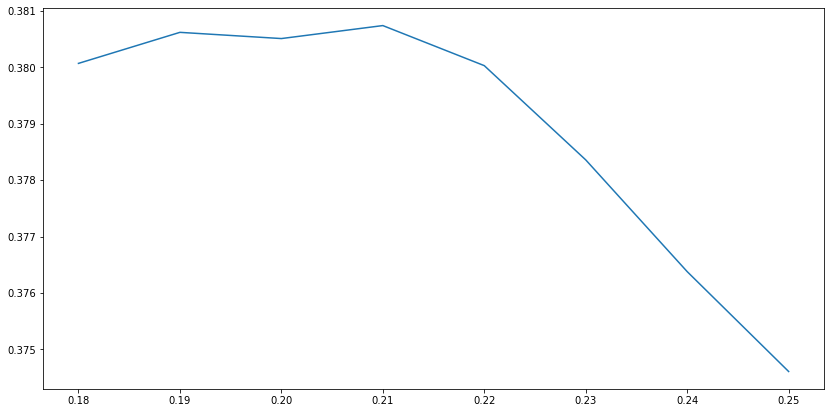

In [55]:
# plotting the scores from different probability thresholds
prob_thresh = [0.25, 0.24, 0.23, 0.22, 0.21, 0.20, 0.19, 0.18]
scores = [0.37461, 0.37638, 0.37836, 0.38003, 0.38074, 0.38051, 0.38062, 0.38007]
plt.plot(prob_thresh, scores)
plt.show()

The plot above shows that the probability threshold of 0.21 results in higher scores.

We'll use this threshold in the following models/predictions.

<b>XGBoost A Params Score</b>

A Params: {
  "objective"           : "binary:logistic",
  "eval_metric"         : "logloss",
  "eta"                 : 0.1,
  "max_depth"           : 6,
  "min_child_weight"    : 10,
  "gamma"               : 0.70,
  "subsample"           : 0.76,
  "colsample_bytree"    : 0.95,
  "alpha"               : 2e-05,
  "lambda"              : 10}

nrounds = 1000 \
probability_threshold = 0.21

Kaggle Score 0.38074

-------------

### 4.2.3 XGBoost new parameters

In [56]:
# split test and train data and features to be discarded 
train = data[data.eval_set == "train"]
test = data[data.eval_set == "test"]
subtrain = train.sample(frac=1.0)
discard_fields = ["eval_set", "user_id", "product_id", "order_id", "reordered"]
X = xgb.DMatrix(subtrain.drop(discard_fields, axis=1), label=subtrain.reordered)

In [57]:
# set model parameters and train
params = {'max_depth':10, 
         'eta':0.02,
         'colsample_bytree':0.4,
         'subsample':0.75,
         'silent':1,
         'nthread':27,
         'eval_metric':'logloss',
         'binary':'logistic',
         'tree_method':'hist'}

#nrounds = 1000 / early_stopping_rounds=40
#lowered to 10 for project evaluation
nrounds = 10

xgb_model = xgb.train(params, X, nrounds, verbose_eval=5)

[16:15:17] WARNING: ..\src\learner.cc:541: 
Parameters: { binary, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [58]:
# save model to file
joblib.dump(xgb_model, "xbg_B_params.joblib")

['xbg_B_params.joblib']

In [59]:
# load model from file
# xgb_model = joblib.load('xbg_B_params.joblib')

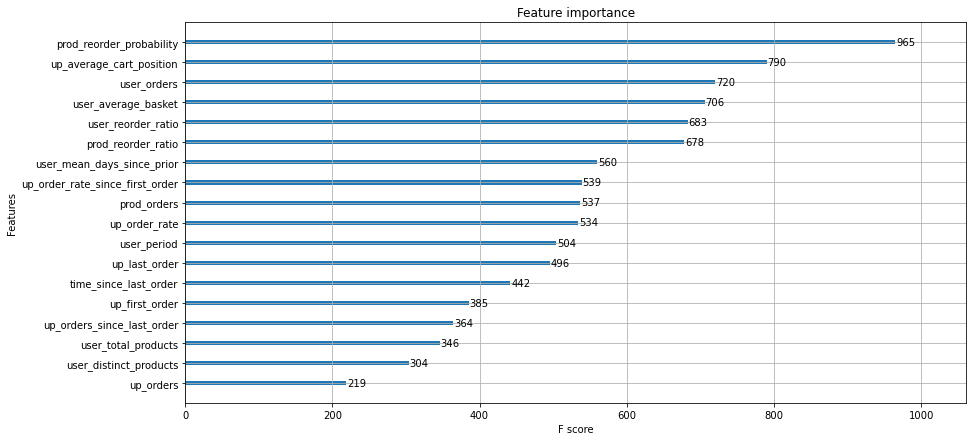

In [60]:
# plotting feature importance
plt.rcParams["figure.figsize"] = (14, 7)
xgb.plot_importance(xgb_model)
plt.show()

In [61]:
# Applying model with a 0.21 probability threshold
probability_threshold = 0.21
X = xgb.DMatrix(test.drop(discard_fields, axis=1))
# predict reordered products
test["reordered"] = xgb_model.predict(X)
test["reordered"] = np.where(test.reordered > probability_threshold, 1, 0)
test.loc[:, 'product_id'] = test.product_id.astype(str)
# join reordered products for submission
submission = test[test.reordered == 1].groupby("order_id").agg({ "product_id" : lambda x: ' '.join(x) })
submission.rename(columns = {"product_id" : "products"}, inplace=True)
submission.reset_index(inplace=True)
# get only the results for the test set
test_set = orders_df[orders_df.eval_set == "test"][["order_id"]]
test_set = test_set.merge(submission, how="outer")
test_set.sort_values("order_id", inplace=True)
# save file for submission
test_set.to_csv(("sample_021_xgb2.csv"), columns=["order_id", "products"], index=False, na_rep="None")
test_set.head(10)

,order_id,products
13407,17,21709 39928 47766 16965 21903 39275 38777 1828...
12775,34,13176 22474 22825 47766 47792 21137 42265 4852...
68056,137,41787 16797 24852 33754 46886 14992 21903 4968...
42239,182,13176 35951 49235 27344 47209 47766 8021 21903...
12915,257,13176 49235 24852 27966 30489 36735 37646 4776...
41326,313,5322 16797 24852 248 21903 49683 45007 13198 1...
63247,353,16797 21137 21573 33000 35561 48183 38768 1554...
20242,386,30450 41787 16797 22124 24852 42356 45066 4776...
44019,414,30450 5322 17224 21376 21709 7503 11777 25659 ...
12171,418,30489 47766 43961 10644 45007 30391 34358 4491...


<b>XGBoost B Params Score</b>

B Params: {
         'max_depth':10, 
         'eta':0.02,
         'colsample_bytree':0.4,
         'subsample':0.75,
         'silent':1,
         'nthread':27,
         'eval_metric':'logloss',
         'binary':'logistic',
         'tree_method':'hist'}

nrounds = 1000 \
probability_threshold = 0.21

Kaggle Score 0.38090

-------------

## 4.3 LightGBM

### 4.3.1 LightGBM Default Parameters

In [62]:
# Auxiliary function to combine the product data into orders
def combi(z,df):
    
    prd_bag = dict()
    z_bag = dict()
    for row in df.itertuples():
        if row.reordered > z:   
            try:
                prd_bag[row.order_id] += ' ' + str(row.product_id)
                z_bag[row.order_id]+= ' ' + str(int(100*row.reordered))
            except:
                prd_bag[row.order_id] = str(row.product_id)
                z_bag[row.order_id]= str(int(100*row.reordered))

    for order in df.order_id:
        if order not in prd_bag:
            prd_bag[order] = ' '
            z_bag[order] = ' '

    return prd_bag,z_bag 

# Auxiliary function to combine the product data into orders using only one threshold value
def combi_single(z,df):
    
    prd_bag = dict()
    for row in df.itertuples():
        if row.reordered > z:   
            try:
                prd_bag[row.order_id] += ' ' + str(row.product_id)
            except:
                prd_bag[row.order_id] = str(row.product_id)

    for order in df.order_id:
        if order not in prd_bag:
            prd_bag[order] = ' '

    return prd_bag

# F1 function uses the actual products as a list in the train set and the list of predicted products
def f1_score_single(x):                

    y_true = x.actual
    y_pred = x.list_prod
    if y_true == '' and y_pred ==[] : return 1.
    y_true = set(y_true)
    y_pred = set(y_pred)
    cross_size = len(y_true & y_pred)
    if cross_size == 0: return 0.
    p = 1. * cross_size / len(y_pred)
    r = 1. * cross_size / len(y_true)
    return 2 * p * r / (p + r)

In [63]:
# get test and train data
train_orders = data[data.eval_set == "train"]
train_orders = train_orders[train_orders['reordered']==1].drop('reordered',axis=1)
orders_df.set_index('order_id', drop=False, inplace=True)
train1=orders_df[['order_id','eval_set']].loc[orders_df['eval_set']=='train']
train1['actual'] = train_orders.groupby('order_id').aggregate({'product_id':lambda x: list(x)})
train1['actual']=train1['actual'].fillna('')
# get average cart size
n_actual = train1['actual'].apply(lambda x: len(x)).mean()
# merge test and train data
test1=orders_df[['order_id','eval_set']].loc[orders_df['eval_set']=='test']
test1['actual']=' '
traintest1=pd.concat([train1,test1])
traintest1.set_index('order_id', drop=True, inplace=True)
# release memory
del train_orders, train1, test1
gc.collect()

0

In [64]:
# filter by eval_set and drop the id's columns
train = data[data['eval_set'] == 'train'].drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis = 1)
test =  data[data['eval_set'] == 'test'].drop(['eval_set', 'user_id', 'reordered'], axis = 1)
check =  data.drop(['eval_set', 'user_id', 'reordered'], axis = 1)

In [65]:
# split train and eval data for LightGBM
X_train, X_eval, y_train, y_eval = train_test_split(
    train[train.columns.difference(['reordered'])], train['reordered'], test_size=0.1, random_state=2)
# release memory
del train
gc.collect()

0

In [66]:
# formatting and training LightGBM with default parameters
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference = lgb_train)
params = {}
warnings.filterwarnings("ignore")
# train model
lgb_model_default = lgb.train(params, lgb_train, num_boost_round = 10, valid_sets = lgb_eval)
# lowered num_boost_round to 10 for project evaluation. Used 1000 for model score results.

# del lgb_train, X_train, y_train
# gc.collect()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.407712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2926
[LightGBM] [Info] Number of data points in the train set: 7610161, number of used features: 18
[LightGBM] [Info] Start training from score 0.097978


In [67]:
# save model to file
joblib.dump(lgb_model_default, "lgb_model_default.joblib")

['lgb_model_default.joblib']

In [68]:
# #load model from file
# lgb_model_default = joblib.load('lgb_model_default.joblib')

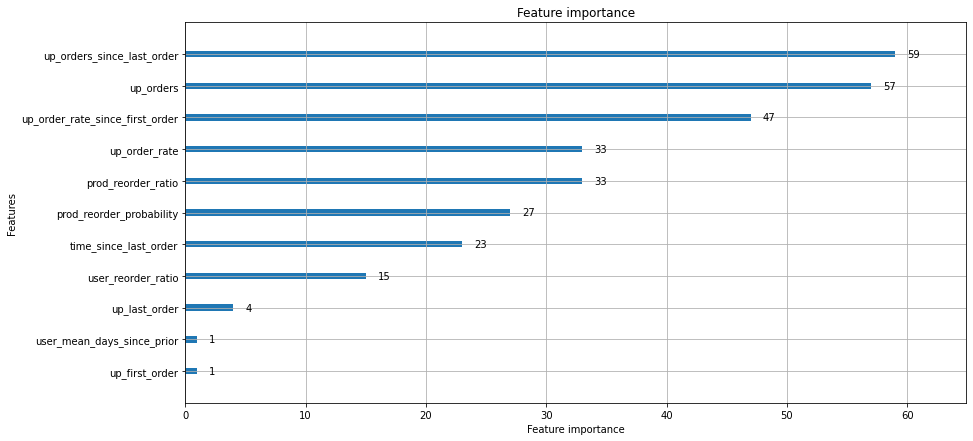

In [69]:
# check feature importance
lgb.plot_importance(lgb_model_default, figsize=(14,7))
plt.show()

In [70]:
# apply model to train and test data
check['reordered'] = lgb_model_default.predict(check[check.columns.difference(
    ['order_id', 'product_id'])], num_iteration = lgb_model_default.best_iteration)

#### Evaluating different probability thresholds for LightGBM Model

In the previous sections, we used 0.21 as the probability threshold.\
To confirm if 0.21 is best for the LightGBM Model, we'll evaluate the scores with different threshold values.

In [71]:
# get a prediction for a range of thresholds
tt=traintest1.copy()
i=0
for z in [0.17, 0.21, 0.25]:  
    
    prd_bag,z_bag = combi(z,check)
    ptemp = pd.DataFrame.from_dict(prd_bag, orient='index')
    ptemp.reset_index(inplace=True)
    ztemp = pd.DataFrame.from_dict(z_bag, orient='index')
    ztemp.reset_index(inplace=True)
    ptemp.columns = ['order_id', 'products']
    ztemp.columns = ['order_id', 'zs']
    ptemp['list_prod'] = ptemp['products'].apply(lambda x: list(map(int, x.split())))
    ztemp['list_z'] = ztemp['zs'].apply(lambda x: list(map(int, x.split())))
    n_cart = ptemp['products'].apply(lambda x: len(x.split())).mean()
    tt.reset_index(inplace=True)
    tt = tt.merge(ptemp,how='inner')
    tt = tt.merge(ztemp,how='inner')
    tt.drop(['products','zs'],axis=1,inplace=True)
    tt['zavg'] = tt['list_z'].apply(lambda x: 0.01*np.mean(x) if x!=[] else 0.).astype(np.float16)
    tt['zmax'] = tt['list_z'].apply(lambda x: 0.01*np.max(x) if x!=[] else 0.).astype(np.float16)
    tt['zmin'] = tt['list_z'].apply(lambda x: 0.01*np.min(x) if x!=[] else 0.).astype(np.float16)
    tt['f1']=tt.apply(f1_score_single,axis=1).astype(np.float16)
    F1 = tt['f1'].loc[tt['eval_set']=='train'].mean()
    tt = tt.rename(columns={'list_prod': 'prod'+str(i), 'f1': 'f1'+str(i), 'list_z': 'z'+str(i),
                'zavg': 'zavg'+str(i), 'zmax': 'zmax'+str(i),  'zmin': 'zmin'+str(i)})
    print(' z,F1,n_actual,n_cart :  ', z,F1,n_actual,n_cart)
    i=i+1
    
tt['fm'] = tt[['f10', 'f11', 'f12']].idxmax(axis=1)
tt['f1'] = tt[['f10', 'f11', 'f12']].max(axis=1)
tt['fm'] = tt.fm.replace({'f10': 0,'f11': 1, 'f12':2}).astype(np.uint8)
print(' f1 maximized ', tt['f1'].loc[tt['eval_set']=='train'].mean())
    
del prd_bag, z_bag, ptemp, ztemp
gc.collect()    

 z,F1,n_actual,n_cart :   0.17 0.3743 6.31446775754712 8.044527639433777
 z,F1,n_actual,n_cart :   0.21 0.3604 6.31446775754712 5.764079162403193
 z,F1,n_actual,n_cart :   0.25 0.3328 6.31446775754712 4.119039421169784
 f1 maximized  0.4304


0

The previous result demonstrates that the 0.21 threshold also gets the highest F1 score for the LightGBM models.

Hence, it will be used in the next LightGBM evaluations.

In [72]:
# get the prediction for the 0.21 threshold only
tt=traintest1.copy()
z = 0.21
# summarizing products and probabilities
prd_bag = combi_single(z,check)
ptemp = pd.DataFrame.from_dict(prd_bag, orient='index')
ptemp.reset_index(inplace=True)
ptemp.columns = ['order_id', 'products']
ptemp['list_prod'] = ptemp['products'].apply(lambda x: list(map(int, x.split())))
tt.reset_index(inplace=True)
tt = tt.merge(ptemp,how='inner')
tt.drop(['products'],axis=1,inplace=True)
# helper function to join reordered products in a list
def pdlist(x):
    prodids = x.list_prod
    if prodids == []: return 'None'            
    if len(prodids) == 1: return  str(prodids[0])+' None'
    if len(prodids) == 2: return  str(prodids[0])+ ' '+ str(prodids[1]) +' None'
    return ' '.join(str(i) for i in prodids)
# Generating csv for submission
tt['list_prod'] = tt.apply(pdlist,axis=1)
tt.rename(columns={'list_prod':'products'}, inplace=True)
tt[tt.eval_set =='test'][['order_id','products']].to_csv('lgbm_default_params.csv', index=False)  

del prd_bag, ptemp
gc.collect()

0

<b> LGBM Default Parameters </b>

Kaggle Score: 0.39184

### 4.3.2 LightGBM parameters

In [73]:
# get test and train data
train_orders = data[data.eval_set == "train"]
train_orders = train_orders[train_orders['reordered']==1].drop('reordered',axis=1)
orders_df.set_index('order_id', drop=False, inplace=True)
train1=orders_df[['order_id','eval_set']].loc[orders_df['eval_set']=='train']
train1['actual'] = train_orders.groupby('order_id').aggregate({'product_id': lambda x: list(x)})
train1['actual'] = train1['actual'].fillna('')
# get average cart size
n_actual = train1['actual'].apply(lambda x: len(x)).mean()   # average cart size
# merge test and train data
test1=orders_df[['order_id','eval_set']].loc[orders_df['eval_set']=='test']
test1['actual'] = ' '
traintest1=pd.concat([train1,test1])
traintest1.set_index('order_id', drop=True, inplace=True)
# release memory
del train_orders, train1, test1
gc.collect()

0

In [74]:
# filter by eval_set and drop the id's columns
train = data[data['eval_set'] == 'train'].drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis = 1)
test =  data[data['eval_set'] == 'test'].drop(['eval_set', 'user_id', 'reordered'], axis = 1)
check =  data.drop(['eval_set', 'user_id', 'reordered'], axis = 1)

In [75]:
# split train and eval data for LightGBM
X_train, X_eval, y_train, y_eval = train_test_split(
    train[train.columns.difference(['reordered'])], train['reordered'], test_size=0.1, random_state=2)
# release memory
del train
gc.collect()

0

In [76]:
# formatting and training LightGBM A Parameters
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference = lgb_train)

params = {'task': 'train',
          'boosting_type'   : 'gbdt',
          'objective'       : 'binary',
          'metric'          : ['binary_logloss', 'auc'],
          'max_bin'         : 100,
          'num_leaves'      : 512,
          'feature_fraction': 0.8,
          'bagging_fraction': 0.95,
          'bagging_freq'    : 5,
          'min_data_in_leaf': 200,
          'learning_rate'   : 0.05}

warnings.filterwarnings("ignore")
# train model
lgb_model_A = lgb.train(params, lgb_train, num_boost_round = 10, valid_sets = lgb_eval, early_stopping_rounds=10)
# lowered num_boost_round to 10 for project evaluation.
# used num_boost_round 1000 for model score results.
# release memory
# del lgb_train, X_train, y_train
# gc.collect()

[LightGBM] [Info] Number of positive: 745628, number of negative: 6864533
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.378078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 7610161, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097978 -> initscore=-2.219896
[LightGBM] [Info] Start training from score -2.219896
[1]	valid_0's binary_logloss: 0.311947	valid_0's auc: 0.819652
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.304392	valid_0's auc: 0.825964
[3]	valid_0's binary_logloss: 0.298177	valid_0's auc: 0.827559
[4]	valid_0's binary_logloss: 0.29297	valid_0's auc: 0.828036
[5]	valid_0's binary_logloss: 0.288472	valid_0's auc: 0.828401
[6]	valid_0's binary_logloss: 0.284796	valid_0's auc: 0.828622
[7]	valid_0's binary_logloss: 0.281596	valid_0's auc: 0.8284

In [77]:
# save model to file
joblib.dump(lgb_model_A, "lgb_A_params.joblib")

['lgb_A_params.joblib']

In [78]:
# # load model from file
# lgb_model_A = joblib.load('lgb_A_params.joblib')

In [79]:
# Applying model to train and test data
check['reordered'] = lgb_model_A.predict(check[check.columns.difference(['order_id', 'product_id'])],
                                       num_iteration = lgb_model_A.best_iteration)

In [80]:
# get the prediction for the 0.21 threshold only
tt=traintest1.copy()
z = 0.21
# summarizing products and probabilities
prd_bag = combi_single(z,check)
ptemp = pd.DataFrame.from_dict(prd_bag, orient='index')
ptemp.reset_index(inplace=True)
ptemp.columns = ['order_id', 'products']
ptemp['list_prod'] = ptemp['products'].apply(lambda x: list(map(int, x.split())))
tt.reset_index(inplace=True)
tt = tt.merge(ptemp,how='inner')
tt.drop(['products'],axis=1,inplace=True)
# Generating csv for submission
tt['list_prod'] = tt.apply(pdlist,axis=1)
tt.rename(columns={'list_prod':'products'}, inplace=True)
tt[tt.eval_set =='test'][['order_id','products']].to_csv('lgbm_A_params.csv', index=False)  
# release memory
del prd_bag, ptemp
gc.collect()

0

In [81]:
# sample of the submission file
tt[tt.eval_set =='test'][['order_id','products']]

,order_id,products
131209,2774568,47766 21903 39190
131210,329954,None
131211,1528013,21903 None
131212,1376945,8309 14947 27959
131213,1356845,13176 7076 None
...,...,...
206204,2728930,24852 26620 2693
206205,350108,43961 30561 15649
206206,1043943,23029 None
206207,2821651,13176 27966 33754 20899 33787 44632 36011 39180


<b>LightGBM A Params Score</b>

A params: {'task': 'train', 'boosting_type': 'gbdt',   'objective': 'binary', 'metric': ['binary_logloss', 'auc'],
    'num_boost_round' : 1000, 'max_bin' : 100, 'num_leaves': 512, 'feature_fraction': 0.8,  'bagging_fraction': 0.95,
    'bagging_freq': 5, 'min_data_in_leaf' : 200, 'learning_rate' : 0.05}
    
Kaggle Score: 0.39139 (Rank #566)

### 4.3.3 LightGBM new parameters

In [82]:
# get test and train data
train_orders = data[data.eval_set == "train"]
train_orders = train_orders[train_orders['reordered']==1].drop('reordered',axis=1)
orders_df.set_index('order_id', drop=False, inplace=True)
train1=orders_df[['order_id','eval_set']].loc[orders_df['eval_set']=='train']
train1['actual'] = train_orders.groupby('order_id').aggregate({'product_id': lambda x: list(x)})
train1['actual'] = train1['actual'].fillna('')
# get average cart size
n_actual = train1['actual'].apply(lambda x: len(x)).mean()   # average cart size
# merge test and train data
test1=orders_df[['order_id','eval_set']].loc[orders_df['eval_set']=='test']
test1['actual'] = ' '
traintest1=pd.concat([train1,test1])
traintest1.set_index('order_id', drop=True, inplace=True)
# release memory
del train_orders, train1, test1
gc.collect()

0

In [83]:
# filter by eval_set and drop the id's columns
train = data[data['eval_set'] == 'train'].drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis = 1)
test =  data[data['eval_set'] == 'test'].drop(['eval_set', 'user_id', 'reordered'], axis = 1)
check =  data.drop(['eval_set', 'user_id', 'reordered'], axis = 1)

In [84]:
# split train and eval data for LightGBM
X_train, X_eval, y_train, y_eval = train_test_split(
    train[train.columns.difference(['reordered'])], train['reordered'], test_size=0.1, random_state=2)
# release memory
del train
gc.collect()

0

In [85]:
# formatting and training LightGBM B Parameters
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference = lgb_train)

params = {'learning_rate': 0.009,
          'max_depth': 10,
          'boosting': 'gbdt',
          'objective': 'binary', 
          'metric':'auc',
          'seed': 4,
          'num_leaves': 64,
          'feature_fraction': 0.8,
          'bagging_fraction': 0.8,
          'bagging_freq': 5} 

warnings.filterwarnings("ignore")
# train model
lgb_model_B = lgb.train(params, lgb_train, num_boost_round = 10, valid_sets = lgb_eval, early_stopping_rounds=10)
# lowered num_boost_round to 10 for project evaluation
# Used num_boost_round 1000 for model score results.

# del lgb_train, X_train, y_train
# gc.collect()

[LightGBM] [Info] Number of positive: 745628, number of negative: 6864533
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.384604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2925
[LightGBM] [Info] Number of data points in the train set: 7610161, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.097978 -> initscore=-2.219896
[LightGBM] [Info] Start training from score -2.219896
[1]	valid_0's auc: 0.816316
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.81836
[3]	valid_0's auc: 0.819903
[4]	valid_0's auc: 0.819955
[5]	valid_0's auc: 0.819825
[6]	valid_0's auc: 0.821374
[7]	valid_0's auc: 0.821979
[8]	valid_0's auc: 0.822668
[9]	valid_0's auc: 0.823096
[10]	valid_0's auc: 0.823111
Did not meet early stopping. Best iteration is:
[10]	valid_0's auc: 0.823111


In [86]:
# save model to file
joblib.dump(lgb_model_B, "lgb_B_params.joblib")

['lgb_B_params.joblib']

In [87]:
# # load model from file
# lgb_model_B = joblib.load('lgb_B_params.joblib')

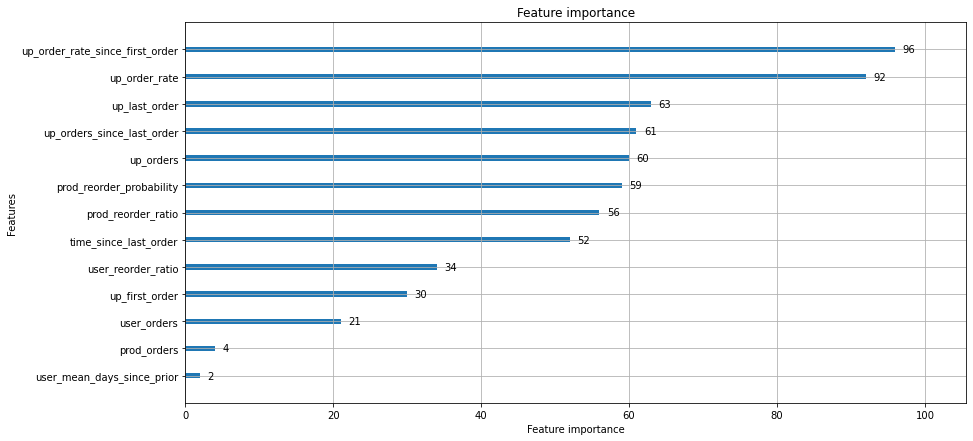

In [88]:
# check feature importance
lgb.plot_importance(lgb_model_B, figsize=(14,7))
plt.show()

In [89]:
# Applying model to train and test data
check['reordered'] = lgb_model_B.predict(check[check.columns.difference(['order_id', 'product_id'])],
                                         num_iteration = lgb_model_B.best_iteration)

In [90]:
# get the prediction for the 0.21 threshold only
tt=traintest1.copy()
z = 0.21
# summarizing products and probabilities    
prd_bag = combi_single(z,check)
ptemp = pd.DataFrame.from_dict(prd_bag, orient='index')
ptemp.reset_index(inplace=True)
ptemp.columns = ['order_id', 'products']
ptemp['list_prod'] = ptemp['products'].apply(lambda x: list(map(int, x.split())))
tt.reset_index(inplace=True)
tt = tt.merge(ptemp,how='inner')
tt.drop(['products'],axis=1,inplace=True)
# Generating csv for submission
tt['list_prod'] = tt.apply(pdlist,axis=1)
tt.rename(columns={'list_prod':'products'}, inplace=True)
tt[tt.eval_set =='test'][['order_id','products']].to_csv('lgbm_B_params.csv', index=False)  
# release memory
del prd_bag, ptemp
gc.collect()

0

<b>LightGBM B Params Score</b>

B Params : {'learning_rate': 0.009, 'max_depth': 10, 'boosting': 'gbdt', 'objective': 'binary', 
          'metric':'auc', 'seed': 4, 'early_stopping_round': 100, 'num_leaves': 64,
          'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5}  
    
Kaggle Score: 0.38528

# 5. Final performance report

In [91]:
# generate table for performance comparison
info = {'Model': ['Baseline (Repeat Last)', 'XGBoost Default',
        'XBGoost A Params', 'XBGoost B Params', 'LightGBM Default', 'LightGBM A Params', 'LightGBM B Params'],
       'Kaggle Score': ['0.216710', '0.378900','0.380740','0.380900','0.38573','0.38495','0.38528'],
       'Increase from Baseline': ['-','74.84%','75.69%','75.76%','77.99%','77.63%','77.79%']}

print(tabulate(info, headers='keys', tablefmt='rst',floatfmt="#.5g", numalign='center', stralign='center'))

======================  ==============  ========================
        Model            Kaggle Score    Increase from Baseline
======================  ==============  ========================
Baseline (Repeat Last)     0.21671                 -
   XGBoost Default         0.37890               74.84%
   XBGoost A Params        0.38074               75.69%
   XBGoost B Params        0.38090               75.76%
   LightGBM Default        0.38573               77.99%
  LightGBM A Params        0.38495               77.63%
  LightGBM B Params        0.38528               77.79%
======================  ==============  ========================


From the table we can visualize that the highest Increase from Baseline was obtained by using the LightGBM models, with an average of 77.8% increase from the baseline and an increase about 2% higher than the obtained with the XGBoost models.

# References

In this work, multiple libraries and projects were consulted and used as reference.\
The following list comprises the most relevant ones that should provide further insights on the subject.

- https://www.kaggle.com/fabienvs/instacart-xgboost-starter-lb-0-3791/code
- https://www.kaggle.com/paulantoine/light-gbm-benchmark-0-3692/code
- https://www.kaggle.com/nickycan/lb-0-3805009-python-edition/notebook
- https://www.kaggle.com/rshally/instacart-lb-392-runs-on-kaggle-with-2nd-clf/notebook
- https://www.kaggle.com/kokovidis/ml-instacart-f1-0-38-part-two-xgboost-f1-max
- https://www.kaggle.com/hongweizhang/how-to-calculate-f1-score/notebook


- https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec
- https://towardsdatascience.com/an-exhaustive-list-of-methods-to-evaluate-recommender-systems-a70c05e121de

In [94]:
#jovian.commit(project='course-project-machine-learning-local', files=['xgb_A_params.joblib', 'xbg_B_params.joblib', 'lgb_model_default.joblib', 'lgb_A_params.joblib', 'lgb_B_params.joblib'])
jovian.commit(project='course-project-machine-learning-local')

<IPython.core.display.Javascript object>

[jovian] Updating notebook "anderson-fm/course-project-machine-learning-local" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/anderson-fm/course-project-machine-learning-local


'https://jovian.ai/anderson-fm/course-project-machine-learning-local'